# Deep Learning Exercise: Advanced Initialization (LSUV) & Adam Optimizer

In this notebook, we will move beyond standard Stochastic Gradient Descent and explore how to make training deep networks faster and more stable.

We will focus on two key areas:
1.  **Weight Initialization**: How we set the starting random numbers matters. We will implement **He Initialization**, **Orthonormal Initialization**, and finally the data-driven **LSUV** initialization.
2.  **Advanced Optimization**: We will implement **Adam**, widely considered the default optimizer for many deep learning tasks.

**Note**: The dataset and the neural network structure (Forward/Backward pass) are provided for you so you can focus strictly on the initialization and update logic.

---

## Instructions

- Fill in all cells marked with **`TODO`**.
- Run the **Sanity Check** cells to verify your work before moving on.
- Compare the results of different initializations and optimizers at the end.

## 1. Setup and Dataset

We will use a **Spiral Dataset**. This is a "hard" classification problem for simple networks because the decision boundary is highly non-linear. It requires a deep network to solve effectively, making it a perfect test case for initialization and optimization.

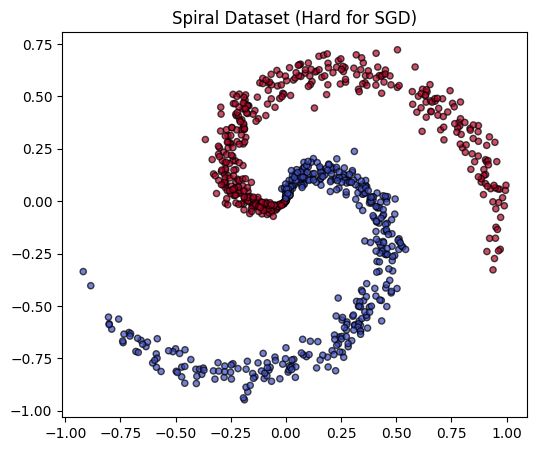

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Deterministic Setup
np.random.seed(42)

def make_spiral_data(points_per_class=300, classes=2):
    """Generates a 2D spiral dataset."""
    rng = np.random.RandomState(123)
    X = np.zeros((points_per_class*classes, 2))
    y = np.zeros(points_per_class*classes, dtype='uint8')

    for j in range(classes):
        ix = range(points_per_class*j, points_per_class*(j+1))
        r = np.linspace(0.0, 1, points_per_class) # radius
        # theta (angle): winding makes it hard for linear classifiers
        t = np.linspace(j*4, (j+1)*4, points_per_class) + rng.randn(points_per_class)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Shuffle
    indices = rng.permutation(len(X))
    X = X[indices]
    y = y[indices]
    return X, y

# Create Data
X, y = make_spiral_data(points_per_class=500)
n_train = int(0.8 * len(X))
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:], y[n_train:]

# Visualization
plt.figure(figsize=(6, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("Spiral Dataset (Hard for SGD)")
plt.show()

## 2. Neural Network Implementation (4-Layer MLP)

To solve the spiral, we need depth. We will use a **4-Layer MLP**:
Input $\to$ H1 $\to$ H2 $\to$ H3 $\to$ Output.

- **Hidden Layers**: ReLU activation.
- **Output Layer**: Softmax (2 classes).

The core logic is implemented below. **You do not need to change this.**

In [5]:
def relu(z):
    return np.maximum(0, z)

def relu_backward(dout, z):
    dz = dout.copy()
    dz[z <= 0] = 0
    return dz

def softmax(logits):
    logits = logits - np.max(logits, axis=1, keepdims=True)
    exp = np.exp(logits)
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy_loss(probs, y_true):
    N = y_true.shape[0]
    log_likelihood = -np.log(probs[np.arange(N), y_true] + 1e-12)
    return np.mean(log_likelihood)

def accuracy(probs, y_true):
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == y_true)

def forward_pass(X, params):
    """Forward pass for a 4-layer network."""
    # Unpack weights
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    W3, b3 = params["W3"], params["b3"]
    W4, b4 = params["W4"], params["b4"]

    # Layer 1
    z1 = X @ W1 + b1
    h1 = relu(z1)

    # Layer 2
    z2 = h1 @ W2 + b2
    h2 = relu(z2)

    # Layer 3
    z3 = h2 @ W3 + b3
    h3 = relu(z3)

    # Output Layer
    logits = h3 @ W4 + b4
    probs = softmax(logits)

    cache = {"X": X, "z1": z1, "h1": h1, "z2": z2, "h2": h2, "z3": z3, "h3": h3, "logits": logits}
    return probs, cache

def backward_pass(probs, cache, params, y_true):
    """Backward pass for a 4-layer network."""
    X = cache["X"]
    z1, h1 = cache["z1"], cache["h1"]
    z2, h2 = cache["z2"], cache["h2"]
    z3, h3 = cache["z3"], cache["h3"]

    W1, W2, W3, W4 = params["W1"], params["W2"], params["W3"], params["W4"]
    N = X.shape[0]

    # dL/dlogits
    dlogits = probs.copy()
    dlogits[np.arange(N), y_true] -= 1
    dlogits /= N

    # Layer 4 Gradients (H3 -> Output)
    dW4 = h3.T @ dlogits
    db4 = np.sum(dlogits, axis=0, keepdims=True)

    # Layer 3 Gradients
    dh3 = dlogits @ W4.T
    dz3 = relu_backward(dh3, z3)
    dW3 = h2.T @ dz3
    db3 = np.sum(dz3, axis=0, keepdims=True)

    # Layer 2 Gradients
    dh2 = dz3 @ W3.T
    dz2 = relu_backward(dh2, z2)
    dW2 = h1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    # Layer 1 Gradients
    dh1 = dz2 @ W2.T
    dz1 = relu_backward(dh1, z1)
    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2,
             "W3": dW3, "b3": db3, "W4": dW4, "b4": db4}
    return grads

## 3. Training Loop

We use a standard training loop that accepts a generic `update_fn` (optimizer) and `init_fn` (initialization strategy).

In [6]:
def train_model(X_train, y_train, X_val, y_val, init_fn, update_fn,
                hidden_dim=16, num_epochs=100, batch_size=64, lr=0.01, seed=42):

    # 1. Initialize Parameters using the provided initialization function
    params = init_fn(input_dim=2, hidden_dim=hidden_dim, output_dim=2, seed=seed)

    # Optimizer state (e.g., for Adam moments)
    opt_state = {}

    N = X_train.shape[0]
    num_batches = int(np.ceil(N / batch_size))
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        # Shuffle deterministically based on epoch number
        rng = np.random.RandomState(epoch)
        indices = rng.permutation(N)
        X_shuffled, y_shuffled = X_train[indices], y_train[indices]

        for b in range(num_batches):
            start, end = b * batch_size, min((b + 1) * batch_size, N)
            X_b, y_b = X_shuffled[start:end], y_shuffled[start:end]

            probs, cache = forward_pass(X_b, params)
            grads = backward_pass(probs, cache, params, y_b)

            # Update parameters
            params, opt_state = update_fn(params, grads, lr, opt_state)

        # Evaluate
        tr_p, _ = forward_pass(X_train, params)
        val_p, _ = forward_pass(X_val, params)

        history["train_loss"].append(cross_entropy_loss(tr_p, y_train))
        history["val_loss"].append(cross_entropy_loss(val_p, y_val))
        history["train_acc"].append(accuracy(tr_p, y_train))
        history["val_acc"].append(accuracy(val_p, y_val))

    return history

## Exercise 1: Weight Initialization Strategies (6P)

We will implement two specific initialization strategies: **He** and **LSUV**.

1.  **He Initialization**: Uses the fan-in of the layer to set the variance. Standard for ReLU.
2.  **Orthonormal**: Initializes weights such that they form an orthogonal basis. This helps preserve gradient norms.
3.  **LSUV**: Uses Orthonormal init as a base, then runs data through the network to scale weights empirically.

---

### a) He Initialization (2P)

Formula for layer $l$:
$$ W^{[l]} \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n_{in}}}\right) $$

**Task**: Implement `init_he` for all 4 layers.

In [7]:
def init_he(input_dim, hidden_dim, output_dim, seed=42):
    """Initialize parameters using He Initialization for 4 layers."""
    rng = np.random.RandomState(seed)
    params = {}

    # Layer 1 (Input -> H1)
    # TODO: Initialize W1:
    params["W1"] = rng.normal(loc=0.0, scale=np.sqrt(2.0 / input_dim), size=(input_dim, hidden_dim))
    params["b1"] = np.zeros((1, hidden_dim))

    # Layer 2 (H1 -> H2)
    # TODO: Initialize W2:
    params["W2"] = rng.normal(loc=0.0, scale=np.sqrt(2.0 / hidden_dim), size=(hidden_dim, hidden_dim))
    params["b2"] = np.zeros((1, hidden_dim))

    # Layer 3 (H2 -> H3)
    # TODO: Initialize W3:
    params["W3"] = rng.normal(loc=0.0, scale=np.sqrt(2.0 / hidden_dim), size=(hidden_dim, hidden_dim))
    params["b3"] = np.zeros((1, hidden_dim))

    # Layer 4 (H3 -> Output)
    # TODO: Initialize W4:
    params["W4"] = rng.normal(loc=0.0, scale=np.sqrt(2.0 / hidden_dim), size=(hidden_dim, output_dim))
    params["b4"] = np.zeros((1, output_dim))

    return params

### b) Orthonormal Initialization (1P)

Standard Gaussian initialization allows random alignment between weight vectors. **Orthonormal initialization** ensures the weight matrix starts as an isometry ($W^T W \approx I$), preserving signal magnitude.

This is usually done via **SVD (Singular Value Decomposition)**:
1. Generate a random matrix $M$.
2. Compute $U, S, V^T = \text{SVD}(M)$. You may use existing solvers, for example implemented in numpy.
3. Use $U$ (or $V^T$) as the weight matrix.

**Task**: Implement `init_orthonormal`.

In [8]:
def create_ortho_matrix(rows, cols, rng):
    """Helper to create a single orthonormal matrix of shape (rows, cols)."""
    # 1. Generate random matrix
    M = rng.randn(rows, cols)

    # 2. Compute SVD
    # TODO:
    U, _, Vt = np.linalg.svd(M, full_matrices=False)

    # 3. Pick the orthogonal part based on shape
    # If rows > cols, u is (rows, cols) (semi-orthogonal columns)
    # If cols > rows, vt is (rows, cols) (semi-orthogonal rows)
    # TODO:
    if rows >= cols:
        W = U
    else:
        W = Vt

    return W

def init_orthonormal(input_dim, hidden_dim, output_dim, seed=42):
    """Initialize weights using Orthonormal matrices."""
    rng = np.random.RandomState(seed)
    params = {}

    # Helper list for dimensions to loop easily
    # Layer 1: (input -> hidden)
    # Layer 2: (hidden -> hidden)
    # Layer 3: (hidden -> hidden)
    # Layer 4: (hidden -> output)
    dims = [(input_dim, hidden_dim),
            (hidden_dim, hidden_dim),
            (hidden_dim, hidden_dim),
            (hidden_dim, output_dim)]

    for i, (din, dout) in enumerate(dims, 1):
        # Initialize W
        params[f"W{i}"] = create_ortho_matrix(din, dout, rng)
        # Initialize b (zeros)
        params[f"b{i}"] = np.zeros((1, dout))

    return params

### c) LSUV (Layer-Sequential Unit-Variance) (3P)

The LSUV paper recommends starting with **Orthonormal** weights, then scaling them based on data. [Mishkin and Matas (2015)](https://arxiv.org/abs/1511.06422).

**Algorithm:**
1. Initialize $W$ with Orthonormal.
2. Pass a batch of data $X$.
3. For each hidden layer, compute std of activations: $\sigma = \text{std}(A)$.
4. Scale weights: $W = W / \sigma$.

**Task**: Implement `apply_lsuv`.

In [ ]:
def apply_lsuv(params, X_batch, tol=0.1):
    """
    Adjusts weights sequentially for Hidden Layers (W1, W2, W3).
    """
    print("Applying LSUV...")
    X = X_batch

    # Loop through the 3 hidden layers (indices 1, 2, 3)
    for i in range(1, 4):
        W_key = f"W{i}"
        b_key = f"b{i}"

        W = params[W_key]
        b = params[b_key]

        # 1. Compute activation (Linear + ReLU)
        # TODO:
        z = X @ W + b
        h = relu(z)

        # 2. TODO: Measure std
        current_std = np.std(h)

        # 3. TODO: Scale if std is far from 1.0
        if np.abs(current_std - 1.0) > tol:
            print(f"  Layer {i} Std before: {current_std:.4f}")

            # TODO: Scaling Factor (add 1e-8 to avoid div by zero)
            scale = 1.0 / (current_std + 1e-8)

            # TODO: Update W and b
            params[W_key] = W * scale
            params[b_key] = b * scale

            # Verify new std (sanity check for log)
            z_new = X @ params[W_key] + params[b_key]
            h = relu(z_new)
            print(f"  Layer {i} Std after:  {np.std(h):.4f}")

        # IMPORTANT: Update X to be the input for the next layer
        X = h

    return params

def init_lsuv_wrapper(input_dim, hidden_dim, output_dim, seed=42):
    """
    Wrapper to fit into training loop.
    1. Init Orthonormal.
    2. Apply LSUV scaling.
    """
    # Start with Orthonormal
    params = init_orthonormal(input_dim, hidden_dim, output_dim, seed)
    # Apply data-driven scaling
    params = apply_lsuv(params, X_train)
    return params

In [10]:
# --- SANITY CHECK: INITIALIZATION ---

# Create dummy parameters and data
dummy_X = np.random.RandomState(99).randn(100, 2)
dummy_params_he = init_he(2, 50, 2, seed=1)
dummy_params_ortho = init_orthonormal(2, 50, 2, seed=1)

# 1. Check He Init Stats (Layer 1)
w1_he_std = np.std(dummy_params_he["W1"])
print(f"He Init W1 std:    {w1_he_std:.4f}")
assert 0.8 < w1_he_std < 1.2, "He Init calculation seems off!"

# 2. Check Orthonormal Property (W^T W should be Identity)
W_ortho = dummy_params_ortho["W2"] # Square matrix (50x50)
prod = W_ortho.T @ W_ortho
is_identity = np.allclose(prod, np.eye(50), atol=1e-6)
print(f"Orthonormal Check: {is_identity}")
assert is_identity, "Orthonormal Init is not creating orthogonal matrices!"

# 3. Check LSUV scaling logic
# We create 'bad' small weights to see if LSUV fixes them
dummy_params_ortho["W1"] *= 0.01
dummy_params_lsuv = apply_lsuv(dummy_params_ortho, dummy_X)

# Verify signals are restored
z_check = dummy_X @ dummy_params_lsuv["W1"] + dummy_params_lsuv["b1"]
a_check = relu(z_check)
final_std = np.std(a_check)
print(f"LSUV Final Std:    {final_std:.4f}")
assert 0.95 < final_std < 1.05, "LSUV did not normalize activations correctly!"

He Init W1 std:    0.8852
Orthonormal Check: True
Applying LSUV...
  Layer 1 Std before: 0.0012
  Layer 1 Std after:  1.0000
  Layer 2 Std before: 0.7620
  Layer 2 Std after:  1.0000
  Layer 3 Std before: 0.6607
  Layer 3 Std after:  1.0000
LSUV Final Std:    1.0000


Expected Output:
```
He Init W1 std:    0.8852
Orthonormal Check: True
Applying LSUV...
  Layer 1 Std before: 0.0012
  Layer 1 Std after:  1.0000
  Layer 2 Std before: 0.7620
  Layer 2 Std after:  1.0000
  Layer 3 Std before: 0.6607
  Layer 3 Std after:  1.0000
LSUV Final Std:    1.0000
```

## Exercise 2: Adam Optimizer (4P)

Adam combines momentum (first moment) and RMSProp (second moment). 

**Formulas:**
1. $m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$
2. $v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$
3. $\hat{m}_t = m_t / (1 - \beta_1^t)$
4. $\hat{v}_t = v_t / (1 - \beta_2^t)$
5. $\theta_t = \theta_{t-1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$

**Task**: Implement `adam_update`.

In [11]:
def adam_update(params, grads, lr, state, beta1=0.9, beta2=0.999, eps=1e-8):
    """
    Adam optimizer update.
    state: dictionary storing 'm', 'v', and 't' (timestep)
    """

    # TODO: Initialize state if empty
    if not state:
        state["t"] = 0
        state["m"] = {}
        state["v"] = {}
        for key in params.keys():
             state["m"][key] = np.zeros_like(params[key])
             state["v"][key] = np.zeros_like(params[key])

    state["t"] += 1
    t = state["t"]

    for k in params.keys():
        g = grads[k]
        # TODO: Implement Adam update step
        state["m"][k] = beta1 * state["m"][k] + (1 - beta1) * g
        state["v"][k] = beta2 * state["v"][k] + (1 - beta2) * (g**2)
        m_hat = state["m"][k] / (1 - beta1 ** t)
        v_hat = state["v"][k] / (1 - beta2 ** t)
        params[k] -= lr * m_hat / (np.sqrt(v_hat) + eps)


    return params, state

In [12]:
# --- SANITY CHECK: ADAM ---

p_k = np.array([1.0, 1.0])
g_k = np.array([0.1, 0.1])
dummy_params = {"W": p_k.copy()}
dummy_grads = {"W": g_k.copy()}
dummy_state = {}

new_params, new_state = adam_update(dummy_params, dummy_grads, lr=0.1, state=dummy_state)

# Manual Calc: m=0.01, v=0.00001, m_hat=0.1, v_hat=0.01, update=0.1
print(f"Original Param: {p_k}")
print(f"New Param:      {new_params['W']}")

assert np.allclose(new_params['W'], [0.9, 0.9], atol=1e-4), "Adam update logic incorrect!"

Original Param: [1. 1.]
New Param:      [0.90000001 0.90000001]


Expected Output:
```
Original Param: [1. 1.]
New Param:      [0.90000001 0.90000001]
```

In [13]:
# Provided: Standard SGD update for comparison
def sgd_update(params, grads, lr, state):
    for k in params.keys():
        params[k] -= lr * grads[k]
    return params, state

## 6. Comparison Experiments

Now we compare four configurations on the Spiral Dataset.
Note that SGD typically needs a higher Learning Rate (0.1 or more) to traverse the spiral arms effectively, while Adam works well with smaller rates (0.01).

1. **He Init + SGD** (LR=0.1)
2. **LSUV + SGD** (LR=0.1)
3. **He Init + Adam** (LR=0.01)
4. **LSUV + Adam** (LR=0.01)

Run the cells below to generate the plots.

Starting Experiments...
Training He + SGD (0.1)...
Training LSUV + SGD (0.1)...
Applying LSUV...
  Layer 1 Std before: 0.0899
  Layer 1 Std after:  1.0000
  Layer 2 Std before: 0.6168
  Layer 2 Std after:  1.0000
  Layer 3 Std before: 0.6053
  Layer 3 Std after:  1.0000
Training He + Adam (0.01)...
Training LSUV + Adam (0.01)...
Applying LSUV...
  Layer 1 Std before: 0.0899
  Layer 1 Std after:  1.0000
  Layer 2 Std before: 0.6168
  Layer 2 Std after:  1.0000
  Layer 3 Std before: 0.6053
  Layer 3 Std after:  1.0000


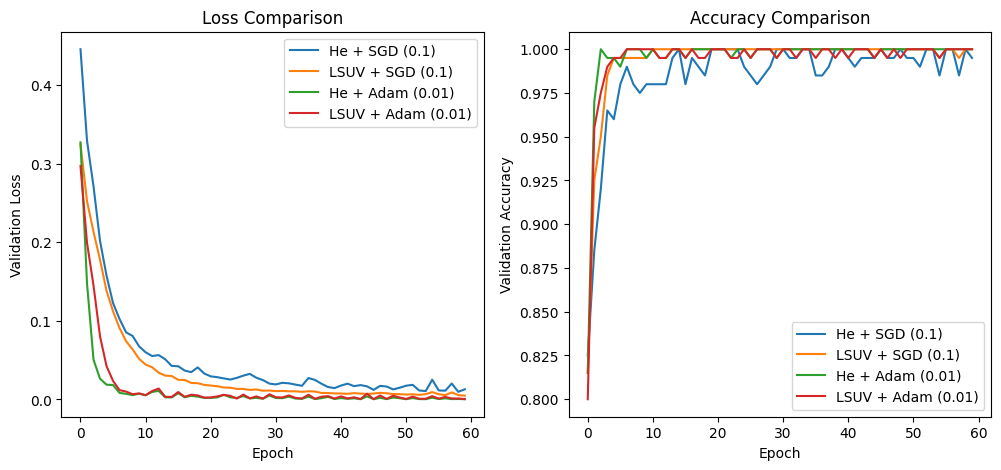

In [14]:
configs = [
    ("He + SGD (0.1)", init_he, sgd_update, 0.1),
    ("LSUV + SGD (0.1)", init_lsuv_wrapper, sgd_update, 0.1),
    ("He + Adam (0.01)", init_he, adam_update, 0.01),
    ("LSUV + Adam (0.01)", init_lsuv_wrapper, adam_update, 0.01),
]

results = {}

print("Starting Experiments...")
for name, init_f, opt_f, l_rate in configs:
    print(f"Training {name}...")
    results[name] = train_model(
        X_train, y_train, X_val, y_val,
        init_fn=init_f,
        update_fn=opt_f,
        lr=l_rate,
        num_epochs=60,    # Increased epochs to see convergence better
        hidden_dim=16     # Balanced width
    )

# --- Plotting Results ---
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
for name, history in results.items():
    plt.plot(history["val_loss"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Loss Comparison")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
for name, history in results.items():
    plt.plot(history["val_acc"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

plt.show()